In this notebook we get visualizations and perform data analysis of the different runs of our model training.

In [8]:

# additional packages

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from os.path import join
import json
import sys
USER = os.getenv('USER')
sys.path.append(F'/home/{USER}/CODE/Pytorch-fingerprints/')


print('Packages loaded')

Packages loaded


In [9]:
def load_metrics(exp_dir, tan=False):
    'Load metrics from the folder exp_dir'
    'tan: True if the tanimoto metric was calculated'
    
    train_losses = np.load(join(exp_dir, 'metrics/LOSS_epoch_train.npy') )
    test_losses = np.load(join(exp_dir, 'metrics/LOSS_epoch_test.npy') )
    test_precisions = np.load(join(exp_dir, 'metrics/precision_epoch_test.npy') )
    test_recalls = np.load(join(exp_dir, 'metrics/recall_epoch_test.npy') )
    test_F1Scores = np.load(join(exp_dir, 'metrics/F1_score_epoch_test.npy') )
    if tan:
        test_tanimotos = np.load(join(exp_dir, 'metrics/tanimoto_epoch_test.npy') )
        return train_losses, test_losses, test_precisions, test_recalls, test_F1Scores, test_tanimotos
    else:
        return train_losses, test_losses, test_precisions, test_recalls, test_F1Scores

def plot_metrics(exp_dir, plot_title='BCE loss (with pos_weights)', tan=False):
    
    if tan:
        train_losses, test_losses, test_precisions, test_recalls, test_F1Scores, test_tanimotos = load_metrics(EXP_DIR, tan=True)
    else:   
        train_losses, test_losses, test_precisions, test_recalls, test_F1Scores = load_metrics(EXP_DIR)
    
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(7, 7))




    axes[0].plot(np.arange(len(train_losses))+1, train_losses, 'y-')
    axes[0].plot(np.arange(len(train_losses))+1, test_losses, 'b-')
    axes[0].set_title(plot_title, fontsize = 13)

    axes[0].legend(['train', 'test'], fontsize = 13)


    axes[1].plot(np.arange(len(train_losses))+1, test_precisions, 'b-')
    axes[1].plot(np.arange(len(train_losses))+1, test_recalls, 'g-')
    axes[1].plot(np.arange(len(train_losses))+1, test_F1Scores, 'r-')
    axes[1].set_xlabel('epoch', fontsize = 13)
   
    
    if tan:
        axes[1].plot(np.arange(len(train_losses))+1, test_tanimotos, 'y-')
        axes[1].legend(['Precision', 'Recall', f'F1 score: F1$_{{max}}$ =  {np.max(test_F1Scores):0.04f}',
                        f'tanimoto: tan$_{{max}}$ =  {np.max(test_tanimotos):0.04f}'], fontsize = 13)
    else:
        axes[1].legend(['Precision', 'Recall', f'F1 score: F1$_{{max}}$ =  {np.max(test_F1Scores):0.04f}']
                       , fontsize = 13)
    

    fig.tight_layout()


def plot_virtual_epochs(models_path, plot_title='metrics'):
    'Plot virtual epochs metrics from model path'
    
    
    with open(os.path.join(models_path, "metrics/virtual_epochs.json"), "r") as read_file:
        metrics_dict = json.load(read_file)

    test_losses, test_precisions, test_recalls, test_F1Scores, test_tanimotos = [], [], [], [], []

    for _, metrics in metrics_dict.items():

        if metrics is None: 
            break

        test_losses.append(metrics["test_loss"])

        # metrics
        test_precisions.append(metrics["precision"])
        test_recalls.append(metrics["recall"])
        test_F1Scores.append(metrics["F1_score"])

        # tanimoto similarity
        test_tanimotos.append(metrics["tanimoto"])


    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(7, 7))

    axes[0].plot(np.arange(len(test_losses))+1, test_losses, 'b-')
    axes[0].set_title(plot_title, fontsize = 13)

    axes[0].legend(['validation loss'], fontsize = 13)


    axes[1].plot(np.arange(len(test_losses))+1, test_precisions, 'b-')
    axes[1].plot(np.arange(len(test_losses))+1, test_recalls, 'g-')
    axes[1].plot(np.arange(len(test_losses))+1, test_F1Scores, 'r-')
    axes[1].set_xlabel('virtual epoch', fontsize = 13)



    axes[1].plot(np.arange(len(test_losses))+1, test_tanimotos, 'y-')
    axes[1].legend(['Precision', 'Recall', f'F1 score: F1$_{{max}}$ =  {np.max(test_F1Scores):0.04f}',
                    f'tanimoto: tan$_{{max}}$ =  {np.max(test_tanimotos):0.04f}'], fontsize = 13)



    fig.tight_layout()
    
def metrics_heatmap(json_path, metric='tanimoto', cmap='gray'):
    
    with open(json_path) as json_file:
        k_metrics_dict = json.load(json_file)
        
    tanimoto_heatmap = np.zeros([4,6])
    for i in range(1,25):
        coords =  ((i - 1) // 6 , (i - 1) % 6)
        if k_metrics_dict[str(i)] is None:
            tanimoto_heatmap[coords] = -1 
        else:
            tanimoto_heatmap[coords] = k_metrics_dict[str(i)][metric]
    ax = sns.heatmap(tanimoto_heatmap.T, cmap=cmap, xticklabels=[40, 60, 80, 100], 
            yticklabels=[40, 60, 80, 100, 120, 140], )

    ax.set_xlabel("k (N/m)", fontsize = 13)
    ax.set_ylabel("Amp (pm)", fontsize = 13)
    ax.set_title(metric, fontsize=15)
    plt.show()
    return tanimoto_heatmap

def plot_virtual_epochs_regression(models_path):
    with open(os.path.join(models_path, "metrics/virtual_epochs.json"), "r") as read_file:
        metrics_dict = json.load(read_file)

    valid_loss, valid_accuracy, acc_C, acc_Br = [], [], [], []
    acc_Cl, acc_F, acc_I, acc_N, acc_O, acc_P, acc_S, acc_H = [], [], [], [], [], [], [], []

    for _, metrics in metrics_dict.items():

            if metrics is None: 
                break

            valid_loss.append(metrics["valid_loss"])

            # metrics
            valid_accuracy.append(metrics["valid_accuracy"])

            acc_C.append(metrics["acc_atom_dict"]["C"])
            acc_Br.append(metrics["acc_atom_dict"]["Br"])
            acc_Cl.append(metrics["acc_atom_dict"]["Cl"])
            acc_F.append(metrics["acc_atom_dict"]["F"])
            acc_I.append(metrics["acc_atom_dict"]["I"])
            acc_N.append(metrics["acc_atom_dict"]["N"])
            acc_O.append(metrics["acc_atom_dict"]["O"])
            acc_P.append(metrics["acc_atom_dict"]["P"])
            acc_S.append(metrics["acc_atom_dict"]["S"])
            acc_H.append(metrics["acc_atom_dict"]["H"])

    plot_title = 'metrics'
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(7, 7))

    axes[0].plot(np.arange(len(valid_loss))+1, valid_loss, 'b-')
    axes[0].set_title(plot_title, fontsize = 13)

    axes[0].legend(['valid loss'], fontsize = 13)

    axes[1].plot(np.arange(len(valid_loss))+1, valid_accuracy)
    axes[1].plot(np.arange(len(valid_loss))+1, acc_C)
    axes[1].plot(np.arange(len(valid_loss))+1, acc_Br)
    axes[1].plot(np.arange(len(valid_loss))+1, acc_Cl)
    axes[1].plot(np.arange(len(valid_loss))+1, acc_F)
    axes[1].plot(np.arange(len(valid_loss))+1, acc_I)
    axes[1].plot(np.arange(len(valid_loss))+1, acc_N)
    axes[1].plot(np.arange(len(valid_loss))+1, acc_O)
    axes[1].plot(np.arange(len(valid_loss))+1, acc_P)
    axes[1].plot(np.arange(len(valid_loss))+1, acc_S)
    axes[1].plot(np.arange(len(valid_loss))+1, acc_H)



    path_list = list(metrics_dict.keys())
    best_epoch = np.argmax(valid_accuracy)
    best_epoch = path_list[best_epoch].split('/')[-1].split('.')[0]

    axes[1].set_xlabel('virtual epoch', fontsize = 13)
    axes[1].set_ylabel('accuracy', fontsize = 13)
    axes[1].legend([f'absolute accuracy: acc_{{max}}=  {np.max(valid_accuracy):0.04f} \n virtual_epoch={best_epoch}', 
                    'C', 'Br', 'Cl', 'F', 'I', 'N', 'O', 'P', 'S', 'H'])


    fig.tight_layout()

In [10]:
EXP_DIR = f'/home/{USER}/CODE/Pytorch-fingerprints/experiments/scratch_adam_default_300k_100_fp'
plot_metrics(EXP_DIR)

FileNotFoundError: [Errno 2] No such file or directory: '/home/mgonzalez/CODE/Pytorch-fingerprints/experiments/scratch_adam_default_300k_100_fp/metrics/LOSS_epoch_train.npy'

In [11]:
train_losses, test_losses, test_precisions, test_recalls, test_F1Scores = load_metrics(EXP_DIR)
test_F1Scores

FileNotFoundError: [Errno 2] No such file or directory: '/home/mgonzalez/CODE/Pytorch-fingerprints/experiments/scratch_adam_default_300k_100_fp/metrics/LOSS_epoch_train.npy'

In [4]:
np.diff(test_F1Scores)*100

NameError: name 'test_F1Scores' is not defined

In [5]:
EXP_DIR = '/home/manuel/CODE/Pytorch-fingerprints/experiments/scratch_adam_default_300k_256_fp'
plot_metrics(EXP_DIR)

FileNotFoundError: [Errno 2] No such file or directory: '/home/manuel/CODE/Pytorch-fingerprints/experiments/scratch_adam_default_300k_256_fp/metrics/LOSS_epoch_train.npy'

In [6]:
EXP_DIR = '/home/manuel/CODE/Pytorch-fingerprints/experiments/scratch_adam_default_300k_512_fp'
plot_metrics(EXP_DIR)

FileNotFoundError: [Errno 2] No such file or directory: '/home/manuel/CODE/Pytorch-fingerprints/experiments/scratch_adam_default_300k_512_fp/metrics/LOSS_epoch_train.npy'

In [10]:
train_losses, test_losses, test_precisions, test_recalls, test_F1Scores = load_metrics(EXP_DIR)
test_F1Scores

array([0.38636494, 0.47611293, 0.48954064, 0.5465076 , 0.5483066 ,
       0.57362723, 0.58320546, 0.5900842 , 0.58958054, 0.6080376 ,
       0.61546373, 0.6141636 , 0.625889  , 0.6282374 , 0.63756424,
       0.61167514, 0.5875995 , 0.6233169 , 0.65587413, 0.63546884,
       0.6543398 , 0.6813651 , 0.65374374, 0.68382996, 0.66318643,
       0.66207963, 0.6914001 , 0.69969743, 0.67870533, 0.6770668 ,
       0.66571116, 0.70698905, 0.6640413 , 0.716495  , 0.69125557,
       0.6865744 , 0.68475485, 0.70731753, 0.7072771 , 0.6900431 ,
       0.6841452 , 0.6924592 , 0.7215196 , 0.6971184 , 0.7099434 ,
       0.71425843, 0.7263212 , 0.7140852 , 0.7290478 , 0.72025836,
       0.70080185, 0.7061241 , 0.7295666 , 0.7383674 , 0.74136794,
       0.7220072 , 0.7110335 , 0.7470106 , 0.7522446 , 0.73533237,
       0.7214908 , 0.736143  , 0.7281418 , 0.75137115, 0.7497409 ,
       0.7182428 , 0.74729466, 0.7413333 , 0.7556703 , 0.7715579 ,
       0.7270402 , 0.73331976, 0.757205  , 0.7337959 , 0.75183

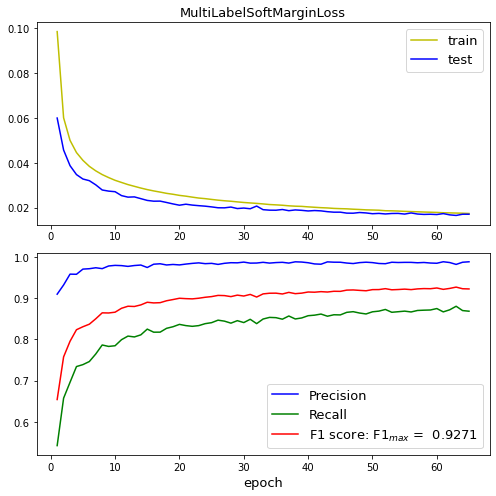

In [11]:
EXP_DIR = '/home/manuel/CODE/Pytorch-fingerprints/experiments/scratch_adam_default_300k_512_fp_MultiLabelSoftMarginLoss'

plot_metrics(EXP_DIR, plot_title='MultiLabelSoftMarginLoss')

In [12]:
train_losses, test_losses, test_precisions, test_recalls, test_F1Scores = load_metrics(EXP_DIR)
print(test_F1Scores)
print(np.diff(test_F1Scores))

[0.654075   0.7576714  0.7955883  0.8236083  0.8308507  0.8370566
 0.8502159  0.8646233  0.8642931  0.8662003  0.8756954  0.88066244
 0.88006413 0.883878   0.89032483 0.88871545 0.8893073  0.89396
 0.89690554 0.90003026 0.899106   0.8985524  0.90011126 0.90243167
 0.90407526 0.906971   0.90649813 0.90403676 0.90761834 0.90545547
 0.9093658  0.90300536 0.91063476 0.91224873 0.91241467 0.9104407
 0.91433823 0.9112067  0.9124689  0.91523707 0.91473556 0.91608864
 0.9151734  0.9169799  0.91678107 0.9198059  0.92022514 0.91915035
 0.91822916 0.920984   0.9211433  0.92334175 0.92060626 0.92125034
 0.92221797 0.9210274  0.9227796  0.92354214 0.92321634 0.9250064
 0.921664   0.92394316 0.9271329  0.92314935 0.9226688 ]
[ 0.10359639  0.0379169   0.02801996  0.00724244  0.00620586  0.01315933
  0.0144074  -0.00033021  0.00190723  0.00949508  0.00496703 -0.00059831
  0.00381386  0.00644684 -0.00160939  0.00059187  0.00465268  0.00294554
  0.00312471 -0.00092423 -0.00055361  0.00155884  0.00232041

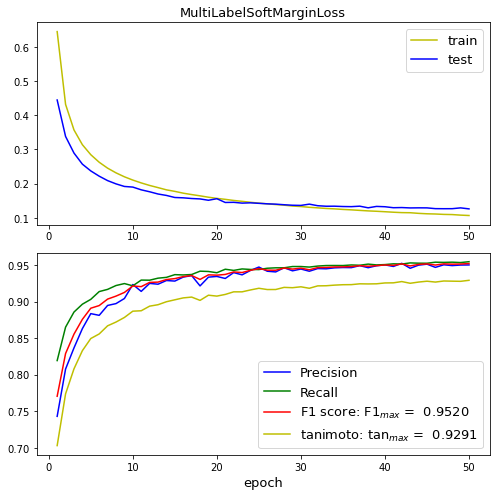

In [13]:
EXP_DIR = '/home/manuel/CODE/Pytorch-fingerprints/experiments/300k_100_fp_tanimoto'

plot_metrics(EXP_DIR, plot_title='MultiLabelSoftMarginLoss', tan=True)

In [14]:
train_losses, test_losses, test_precisions, test_recalls, test_F1Scores = load_metrics(EXP_DIR)
print(test_F1Scores[:36])
print(np.diff(test_F1Scores))

[0.7704207  0.828877   0.85540694 0.87566614 0.890897   0.8945149
 0.90336573 0.9074646  0.91248316 0.9212563  0.9204288  0.9262088
 0.92661667 0.9301003  0.93141556 0.93414146 0.9356296  0.93027437
 0.9365541  0.9361143  0.93711466 0.94053173 0.9397197  0.9427533
 0.94509107 0.94298923 0.94288766 0.9458204  0.944456   0.9457068
 0.9434986  0.9464711  0.9466491  0.9473169  0.9474318  0.94785106]
[ 0.0584563   0.02652997  0.0202592   0.01523083  0.00361794  0.00885081
  0.00409889  0.00501853  0.00877315 -0.00082749  0.00577998  0.00040787
  0.00348365  0.00131524  0.0027259   0.00148815 -0.00535524  0.00627971
 -0.00043976  0.00100034  0.00341707 -0.00081205  0.00303364  0.00233775
 -0.00210184 -0.00010157  0.00293273 -0.00136441  0.0012508  -0.00220817
  0.00297248  0.00017798  0.00066781  0.00011492  0.00041926  0.00123537
 -0.000772    0.0008325   0.00092214 -0.00059837  0.00206321 -0.00273186
  0.00203907  0.00066352 -0.00153565  0.00161982 -0.00040287  0.00017726
  0.00063831]


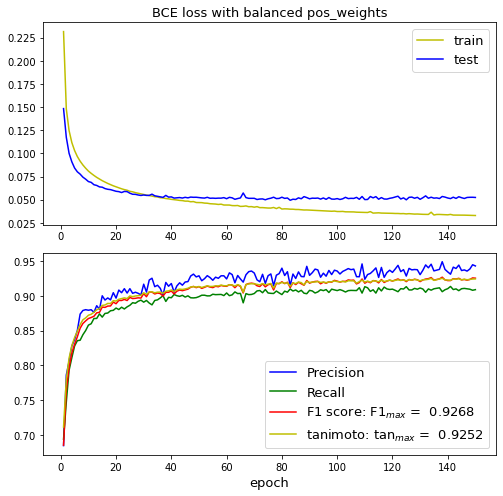

In [15]:
EXP_DIR = '/home/manuel/CODE/Pytorch-fingerprints/experiments/300k_512_fp_tanimoto'

plot_metrics(EXP_DIR, plot_title='BCE loss with balanced pos_weights', tan=True)

In [16]:
train_losses, test_losses, test_precisions, test_recalls, test_F1Scores = load_metrics(EXP_DIR)
print(test_F1Scores[87])
print(np.diff(test_F1Scores))

0.91523224
[ 7.88016319e-02  3.29211950e-02  2.07597017e-02  1.29442215e-02
  1.06634498e-02  1.23032928e-02  6.76351786e-03  3.75729799e-03
  3.39531898e-03  1.47759914e-03  1.78229809e-03  4.93061543e-03
  7.44760036e-04  7.53569603e-03 -4.24683094e-04  1.89077854e-03
  1.60753727e-04  5.58096170e-03 -2.36535072e-03  4.75567579e-03
 -1.04784966e-04  1.56599283e-03 -1.62953138e-03  4.48966026e-03
 -1.65754557e-03  3.58104706e-04  7.18533993e-04 -3.70264053e-04
  6.37674332e-03 -4.43547964e-03  6.78032637e-03 -1.07705593e-04
 -2.70295143e-03  1.42848492e-03 -8.58485699e-04 -3.63105536e-03
  5.38152456e-03  1.48594379e-04  1.77603960e-03 -4.24391031e-03
  3.94344330e-03  1.76954269e-03 -9.56892967e-04  1.06650591e-03
  1.12676620e-03  2.64054537e-03  1.28090382e-03 -1.78283453e-03
  1.51562691e-03 -2.55966187e-03  1.54840946e-03  1.72394514e-03
 -1.37048960e-03 -7.83741474e-04  1.92117691e-03 -7.06195831e-04
  1.87134743e-03 -9.03487206e-04 -3.22520733e-04  2.35080719e-03
 -5.49077988e-

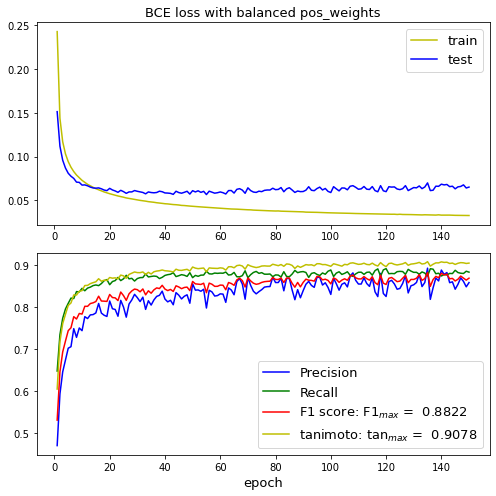

In [3]:
EXP_DIR = '/home/manuel/CODE/Pytorch-fingerprints/experiments/300k_1024_fp_tanimoto'

plot_metrics(EXP_DIR, plot_title='BCE loss with balanced pos_weights', tan=True)

In [7]:
train_losses, test_losses, test_precisions, test_recalls, test_F1Scores, test_tanimotos = load_metrics(EXP_DIR, tan=True)
print(test_tanimotos[149])
print(np.diff(test_tanimotos))

0.9044286
[ 1.1277950e-01  4.2712986e-02  2.2176385e-02  2.1063805e-02
  6.0219169e-03  1.8953562e-02 -1.6742945e-04  9.0209246e-03
  1.3692379e-03  1.2253046e-02  3.0201674e-04  4.2135715e-03
  2.3248196e-03  2.0263791e-03  7.2556734e-03 -5.9812665e-03
  2.5624633e-03 -7.8624487e-04  7.1693063e-03 -1.6767383e-03
  8.2868338e-04 -2.3325682e-03  8.8726878e-03 -1.8448234e-03
 -5.7798028e-03  9.2203617e-03  2.8426051e-03  2.9715896e-03
 -1.5220642e-03 -1.4519691e-04  1.7713308e-03 -5.9525371e-03
  4.9759150e-03 -3.9226413e-03  5.2616596e-03  1.6976595e-03
  8.4674358e-04  1.7132759e-03 -1.8427372e-03 -4.8738718e-04
 -8.7922812e-04 -1.4889240e-03  6.5201521e-03 -2.4608970e-03
 -3.4099817e-04  1.4009476e-03  1.1228323e-03 -3.9350986e-03
  9.4048977e-03 -2.6105046e-03 -1.2849569e-03  6.9892406e-04
  8.6867809e-04 -9.1517568e-03  9.4251633e-03 -7.3158741e-04
 -3.2573938e-04 -2.2488832e-04  1.3786554e-03 -8.1163645e-04
 -4.4713616e-03  7.8977346e-03  1.5687943e-04 -2.6178360e-03
  5.2039027e-0

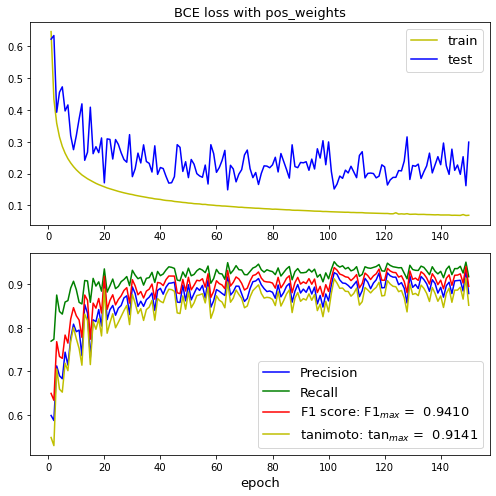

In [21]:


EXP_DIR = '/home/manuel/CODE/Pytorch-fingerprints/experiments/300k_100_bit_w_noise_std_2'

plot_metrics(EXP_DIR, plot_title='BCE loss with pos_weights', tan=True)

In [29]:
train_losses, test_losses, test_precisions, test_recalls, test_F1Scores, test_tanimotos = load_metrics(EXP_DIR, tan=True)
print(test_tanimotos[0:10])
print(np.diff(test_tanimotos))

[0.54781985 0.5291781  0.7054936  0.6589565  0.6520859  0.7185222
 0.7014422  0.76841307 0.80068123 0.77515453]
[-1.86417699e-02  1.76315546e-01 -4.65371013e-02 -6.87062740e-03
  6.64362907e-02 -1.70800090e-02  6.69708848e-02  3.22681665e-02
 -2.55267024e-02 -2.27770209e-02 -3.83469462e-02  1.17603421e-01
 -1.51439309e-02 -1.01031065e-01  9.88583565e-02 -1.77049041e-02
  2.39043236e-02 -3.92110944e-02  1.07753575e-01 -1.01558447e-01
  2.39992142e-02  2.08112597e-02 -3.22182775e-02  1.25998259e-02
  1.34905577e-02  1.33223534e-02  1.19785666e-02 -4.41726446e-02
  6.91899061e-02 -2.04240084e-02 -2.34118104e-02  1.13632679e-02
 -2.71007419e-02  2.50595212e-02  5.48362732e-03  1.54190063e-02
 -4.54498529e-02  4.97518182e-02 -6.31040335e-03 -3.30007076e-03
  1.89363360e-02  1.21426582e-02 -9.54806805e-04 -3.71623039e-03
 -4.97035980e-02 -1.47193670e-03  4.06644940e-02 -3.07759643e-02
  3.98143530e-02 -3.61904502e-02  1.09010935e-02  1.69662833e-02
  1.56086683e-03  2.57110596e-03 -2.1134674

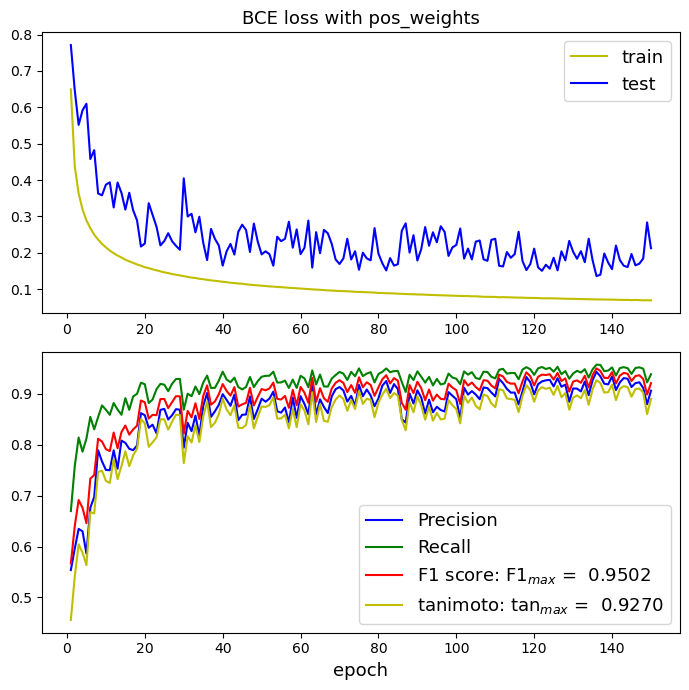

In [4]:

EXP_DIR = '/home/manuel/CODE/Pytorch-fingerprints/experiments/300k_100_bit_3_images_1_4_7'

plot_metrics(EXP_DIR, plot_title='BCE loss with pos_weights', tan=True)

In [23]:
train_losses, test_losses, test_precisions, test_recalls, test_F1Scores, test_tanimotos = load_metrics(EXP_DIR, tan=True)
print(test_tanimotos[149])
print(np.diff(test_tanimotos))

0.89025897
[ 0.08468276  0.0640263  -0.01655763 -0.02441323  0.10427564 -0.00268644
  0.08155835  0.00247353 -0.01994163 -0.00421804  0.04653829 -0.03906989
  0.02588671  0.02874911 -0.0290361   0.02138072  0.01284975  0.057998
 -0.00803858 -0.04620767  0.00898445  0.00939459  0.03587729 -0.00053483
 -0.01997513  0.01572073  0.01362818 -0.00070137 -0.09430921  0.05281842
 -0.01250285  0.03391439 -0.03291446  0.05039555  0.02915305 -0.05011529
  0.00838095  0.01673532  0.03081381 -0.02157652 -0.01112938  0.0196752
 -0.0440495  -0.00104398  0.00641954  0.03823805 -0.04498011  0.02303493
  0.01979363 -0.00074357  0.00313276  0.01557362 -0.04169571  0.00029218
  0.00730461 -0.02681655  0.0385415  -0.03594887  0.04475385 -0.01216149
 -0.02721024  0.06321287 -0.05872804  0.03528196 -0.03302741 -0.00160557
  0.02882731  0.01477051  0.00799501 -0.00723451 -0.02275002  0.02095985
 -0.01764297  0.03560609 -0.02560323  0.01050222 -0.00271499 -0.03376442
  0.02863371  0.01556629  0.01173192 -0.018

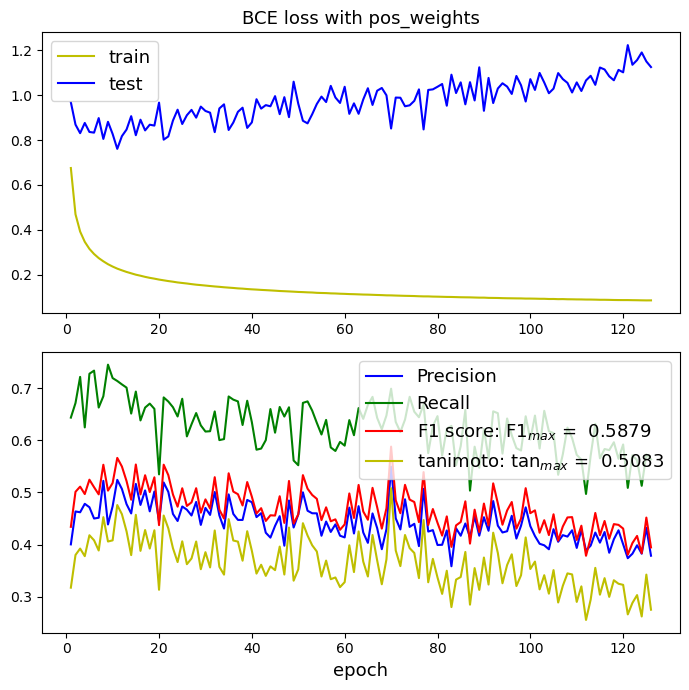

In [3]:


EXP_DIR = '/home/manuel/CODE/Pytorch-fingerprints/experiments/300k_100_bit_1_image'

plot_metrics(EXP_DIR, plot_title='BCE loss with pos_weights', tan=True)

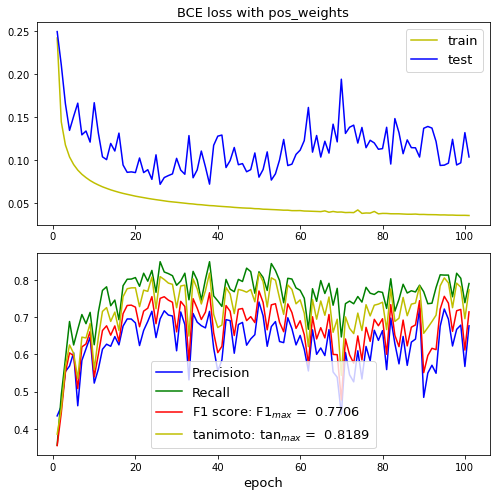

In [25]:

EXP_DIR = '/home/manuel/CODE/Pytorch-fingerprints/experiments/300k_1024_bit_3_images_2_5_8'

plot_metrics(EXP_DIR, plot_title='BCE loss with pos_weights', tan=True)

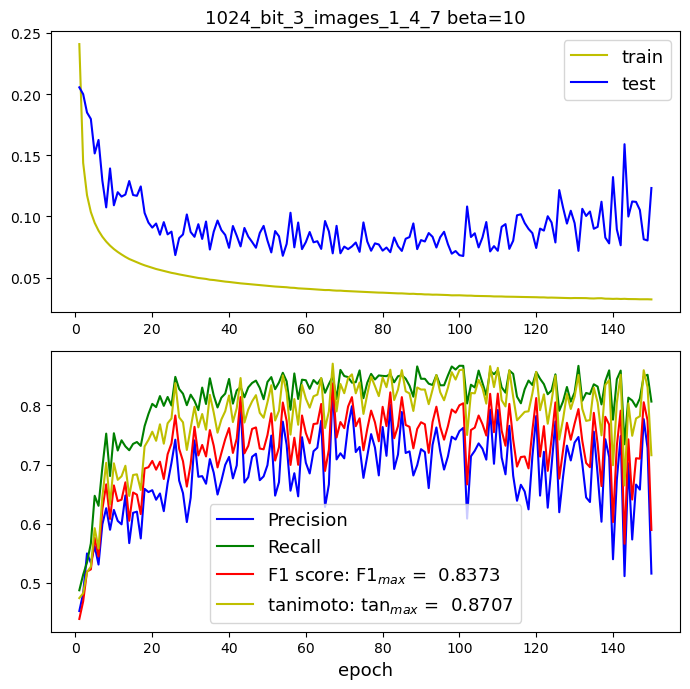

In [10]:

EXP_DIR = '/home/manuel/CODE/Pytorch-fingerprints/experiments/300k_1024_bit_3_images_1_4_7'

plot_metrics(EXP_DIR, plot_title='1024_bit_3_images_1_4_7 beta=10', tan=True)

In [6]:
train_losses, test_losses, test_precisions, test_recalls, test_F1Scores, test_tanimotos = load_metrics(EXP_DIR, tan=True)
print(test_recalls-test_precisions)


[ 0.03500664  0.03176618 -0.0153001   0.03286797  0.0850727   0.09923518
  0.09624267  0.12607849  0.09085941  0.12959176  0.11892331  0.14205354
  0.08296937  0.15691566  0.11648571  0.11768532  0.1564576   0.10595399
  0.1319325   0.14585811  0.15652788  0.16458929  0.1779955   0.14570212
  0.09691811  0.10618216  0.15482658  0.16803157  0.1975109   0.1741178
  0.06672746  0.11263061  0.14966935  0.13475865  0.13663709  0.13043594
  0.14713967  0.14045101  0.12043726  0.13178825  0.12631005  0.12656593
  0.02707374  0.14413643  0.15174133  0.12474543  0.12362731  0.15592802
  0.13042527  0.14063877  0.09884453  0.17988276  0.16855574  0.08252227
  0.10750407  0.13674021  0.16855675  0.16450667  0.09724617  0.13951999
  0.14309037  0.12031025  0.10774904  0.07168227  0.19293195  0.16955101
  0.01866817  0.10211051  0.14092708  0.13909549  0.0822053   0.0398255
  0.1181379   0.12934053  0.13463384  0.12358105  0.10176933  0.11498642
  0.1689502   0.08643615  0.13462031  0.05220848  0.1

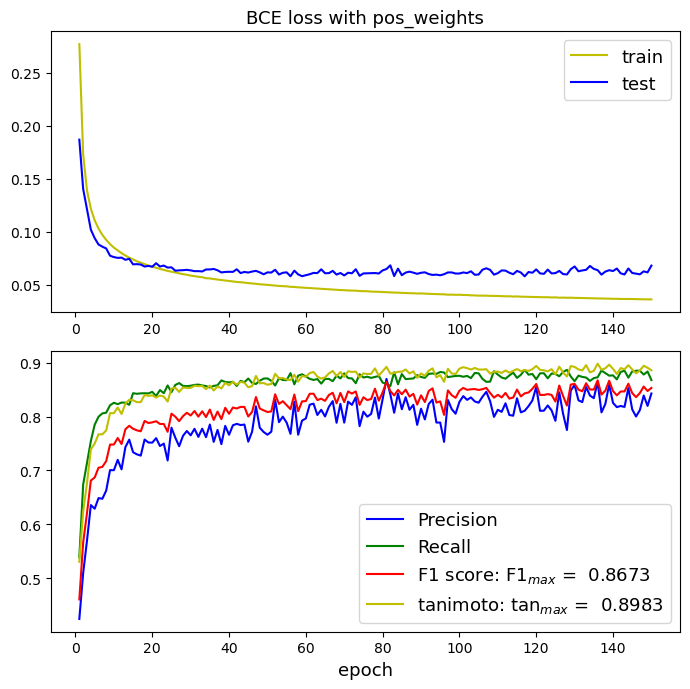

In [3]:

EXP_DIR = '/home/manuel/CODE/Pytorch-fingerprints/experiments/300k_1024_bit_big_zoom'

plot_metrics(EXP_DIR, plot_title='BCE loss with pos_weights', tan=True)

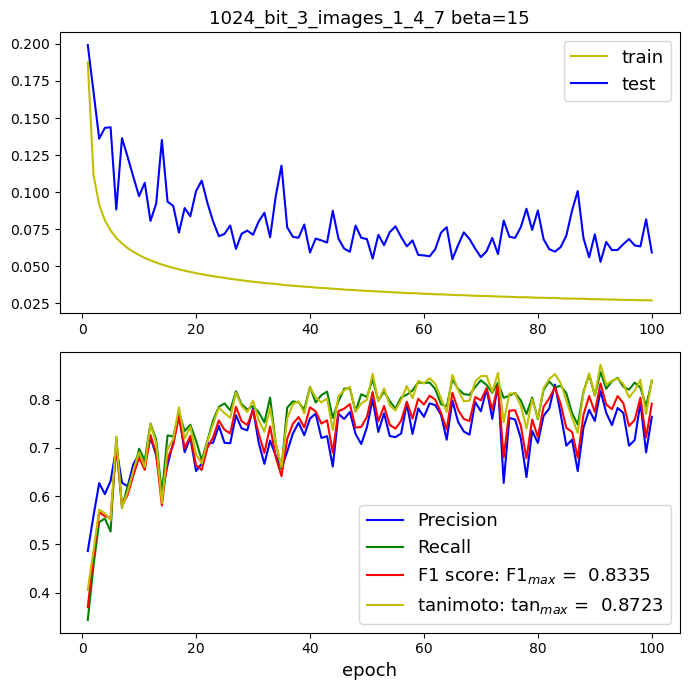

In [12]:
EXP_DIR = '/home/manuel/CODE/Pytorch-fingerprints/experiments/300k_1024_bit_3_images_1_4_7_beta_15'

plot_metrics(EXP_DIR, plot_title='1024_bit_3_images_1_4_7 beta=15', tan=True)

In [8]:
train_losses, test_losses, test_precisions, test_recalls, test_F1Scores, test_tanimotos = load_metrics(EXP_DIR, tan=True)
print(test_recalls-test_precisions)

[-0.14282364 -0.10314152 -0.08078074 -0.05024868 -0.10472548  0.0216186
 -0.05205357  0.00110328 -0.0213663   0.01195872  0.00865728  0.02902865
  0.03282702 -0.00246888  0.06100267  0.01248997  0.0045616   0.04391086
  0.02634138  0.06289703  0.00734985  0.00583696  0.04660124  0.03927541
  0.08162606  0.06801444  0.0495941   0.04994231  0.04335922  0.00539702
  0.0634138   0.08585763  0.08891594  0.02551293 -0.00094235  0.09100938
  0.06649607  0.0420869   0.05304921  0.06571871  0.02294528  0.08862525
  0.09230006  0.10064042  0.0260511   0.06273919  0.0493356   0.0468303
  0.10310954  0.0625723   0.04108316  0.0650084   0.04485571  0.07238823
  0.05928123  0.07471603  0.01843512  0.09028161  0.05395329  0.06972015
  0.04317379  0.03297603  0.0220204   0.06920564  0.04398298  0.06852484
  0.07739323  0.0825572   0.03110689  0.0642693   0.00767481  0.05383265
  0.00351173  0.17609584  0.04609281  0.05478132  0.07800919  0.13067126
  0.06873101  0.04922277  0.0541749   0.05585241 -0.0

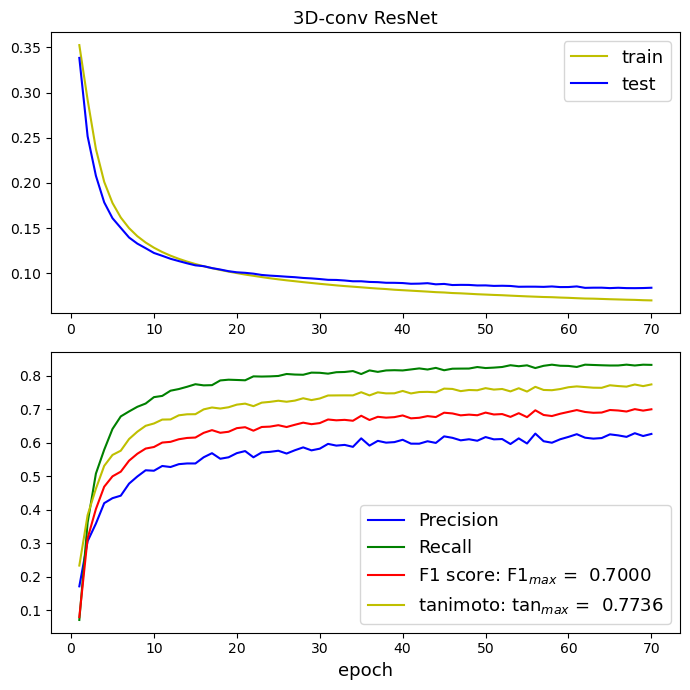

In [3]:
EXP_DIR = '/home/manuel/CODE/Pytorch-fingerprints/experiments/300k_1024_bit_ResNet-3D'

plot_metrics(EXP_DIR, plot_title='3D-conv ResNet', tan=True)




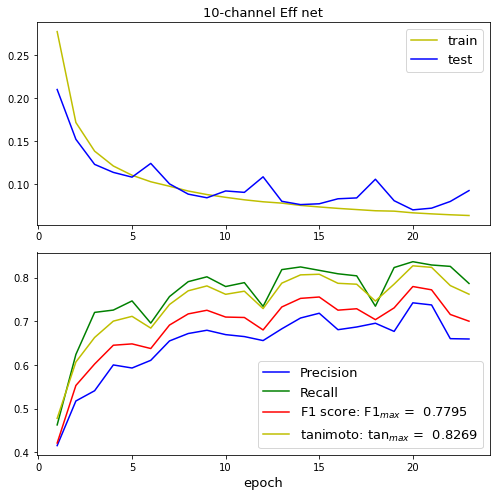

In [3]:

EXP_DIR = '/home/manuel/CODE/Pytorch-fingerprints/experiments/debug_300k_1024_1_6_ks'

plot_metrics(EXP_DIR, plot_title='10-channel Eff net', tan=True)

In [4]:
train_losses, test_losses, test_precisions, test_recalls, test_F1Scores, test_tanimotos = load_metrics(EXP_DIR, tan=True)
print(test_tanimotos)

[0.47768316 0.6066553  0.66276675 0.7002227  0.7111873  0.6841911
 0.7382696  0.76966536 0.78082347 0.76163286 0.7687502  0.7289262
 0.78720254 0.80613    0.8075427  0.78682554 0.78473353 0.74617213
 0.7849822  0.82685184 0.82337034 0.78160816 0.76188874]


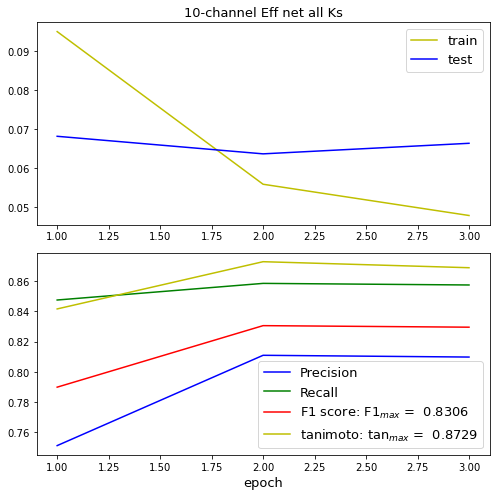

In [3]:

EXP_DIR = '/home/manuel/CODE/Pytorch-fingerprints/experiments/300k_1024_all_ks'

plot_metrics(EXP_DIR, plot_title='10-channel Eff net all Ks', tan=True)

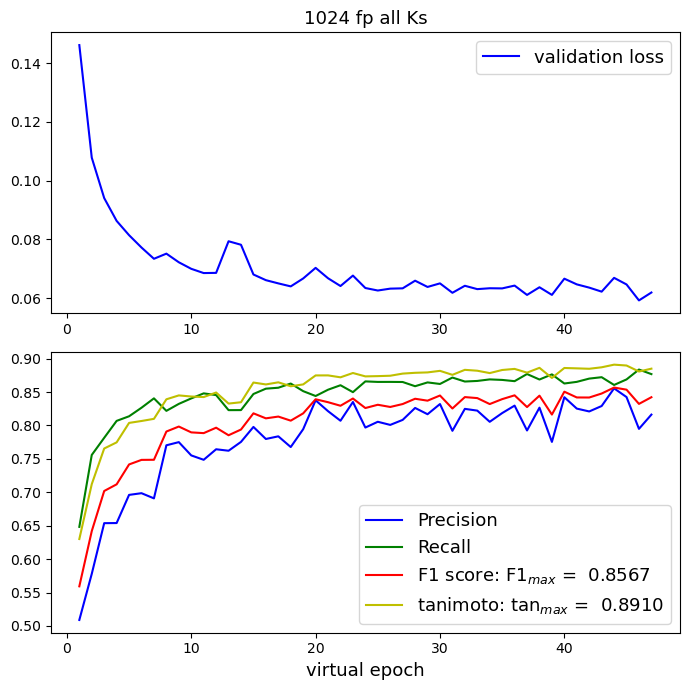

In [7]:
models_path = '/home/manuel/CODE/Pytorch-fingerprints/experiments/300k_1024_all_ks_dropout_0_5'

    
plot_virtual_epochs(models_path, plot_title='1024 fp all Ks')

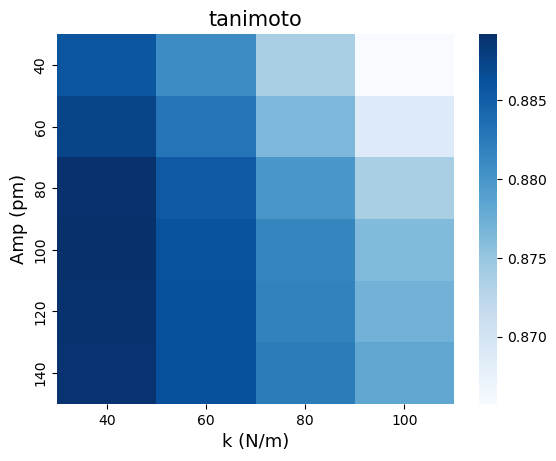

array([[0.88581055, 0.88737744, 0.8891049 , 0.88920683, 0.88897097,
        0.88888204],
       [0.88083416, 0.88297915, 0.88546985, 0.88609469, 0.88627541,
        0.88628894],
       [0.87380236, 0.876414  , 0.87987083, 0.88157672, 0.88187051,
        0.88240623],
       [0.86574054, 0.86880338, 0.8737731 , 0.87628055, 0.87705976,
        0.87830538]])

In [15]:
json_path = ('/home/manuel/CODE/Pytorch-fingerprints/experiments/300k_1024_all_ks/' +
'metrics/k_metrics_checkpoint_5_virtual_epoch_1.pth.json')

metrics_heatmap(json_path, metric='tanimoto', cmap='Blues')

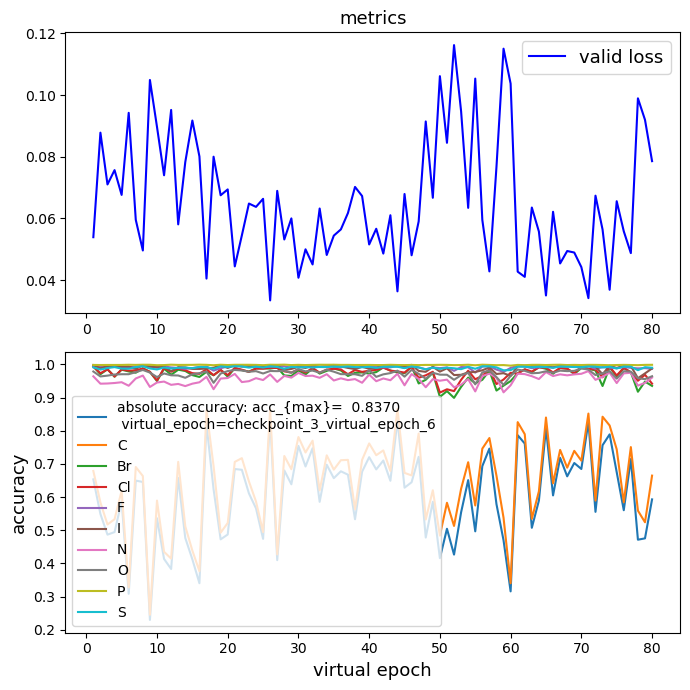

In [10]:
models_path = '/home/manuel/CODE/Pytorch-fingerprints/experiments/regression/'    
plot_virtual_epochs_regression(models_path)

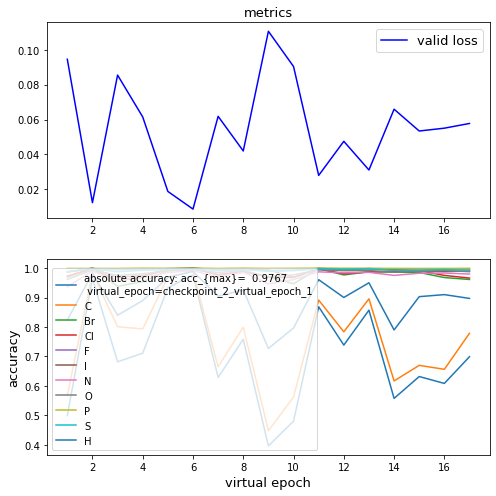

In [3]:
models_path = '/home/manuel/CODE/Pytorch-fingerprints/experiments/regression_w_H/'    
plot_virtual_epochs_regression(models_path)

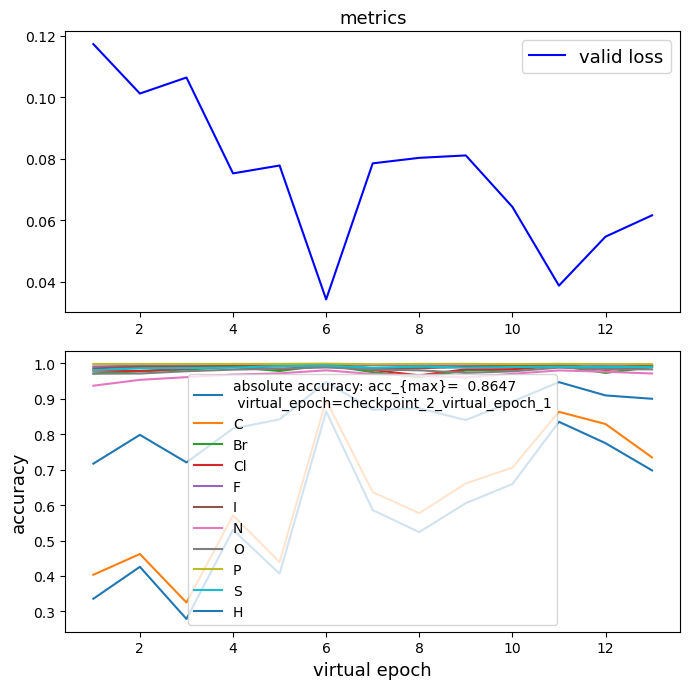

In [7]:
models_path = '/home/manuel/CODE/Pytorch-fingerprints/experiments/regression_w_H_lr_5e-4'    
plot_virtual_epochs_regression(models_path)